In [1]:
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import OrderedDict
from plotting import line_plot_predictions, plot_cross_val_score
from baseline_models import Baseline_previous, Baseline_average, baseline_forecasts
from sarima_models import Sarima_predictions
from data_wrangling import Results_data, Data_preparation
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
project_name = 'project_e871'
freq = 'H'
season = 24
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [16]:
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
path_res = '../results/results_hourly/output_'+project_name+'_hourly'
results = Results_data(path_res).get_data().df
res_sarima = results[results['model']=='sarima']
res_sarimax = results[results['model']=='sarimaX']
results

,baseline_averages,baseline_previous,beta_var,model,order,project,sarima_x_aic,sarimax,sarimax_params,seasonal_order,test
0,6076.692819,8670.245998,0,sarima,"(0, 1, 1)",project_e871,NaN,2734.638054,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(1, 0, 1, 2)",0
1,16138.361027,25936.366386,0,sarima,"(0, 1, 1)",project_e871,NaN,15802.842313,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(1, 0, 1, 2)",1
2,6076.692819,8670.245998,0,sarimaX,"(0, 1, 1)",project_e871,NaN,3208.006342,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1, 2)",0
3,16138.361027,25936.366386,0,sarimaX,"(0, 1, 1)",project_e871,NaN,21045.206771,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1, 2)",1
0,6740.268917,18631.442711,1,sarima,"(0, 1, 1)",project_e871,26487.602306,2734.638053,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(1, 0, 1, 2)",0
1,16138.361027,25936.366386,1,sarima,"(0, 1, 1)",project_e871,28035.494746,15802.838005,"{'k_ma': 1, 'k_exog': 0, 'measurement_error': ...","(1, 0, 1, 2)",1
2,6740.268917,18631.442711,1,sarimaX,"(0, 1, 1)",project_e871,26762.290313,3528.641685,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1, 2)",0
3,16138.361027,25936.366386,1,sarimaX,"(0, 1, 1)",project_e871,28226.499710,21104.126116,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(0, 0, 1, 2)",1


In [17]:
params_s = (res_sarima.iloc[0]['order'],res_sarima.iloc[0]['seasonal_order'])
params_sX = (res_sarimax.iloc[0]['order'],res_sarimax.iloc[0]['seasonal_order'])
params_sX_v = (res_sarimax.iloc[2]['order'],res_sarimax.iloc[2]['seasonal_order'])
print params_s
print params_sX
print params_sX_v

((0, 1, 1), (1, 0, 1, 2))
((0, 1, 1), (0, 0, 1, 2))
((0, 1, 1), (0, 0, 1, 2))


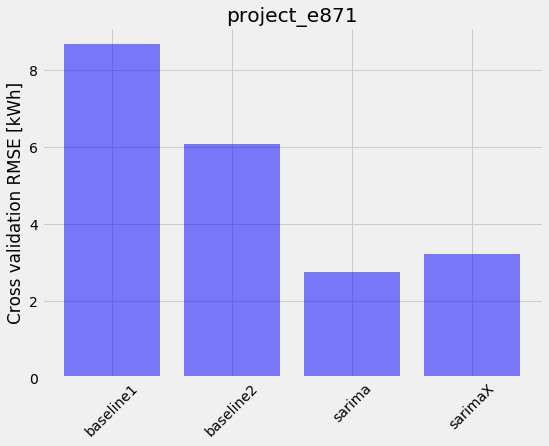

In [18]:
plot_cross_val_score(results)

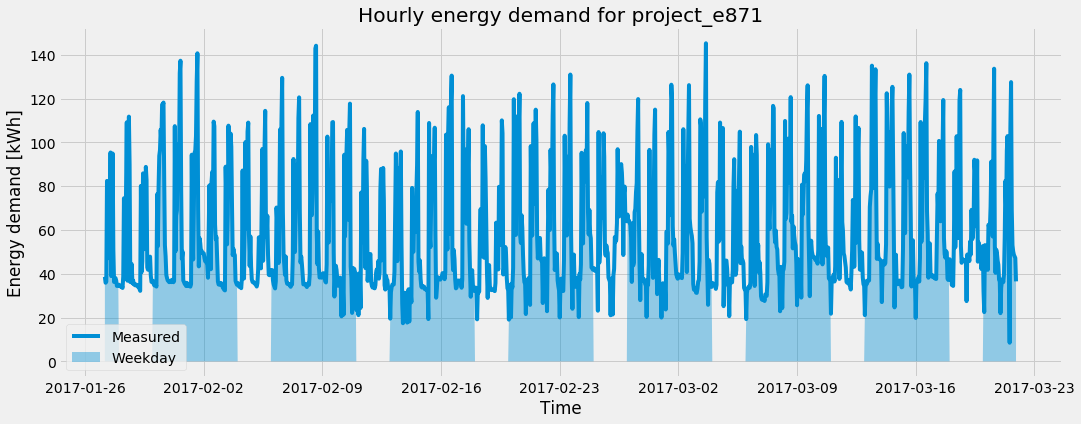

In [19]:
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

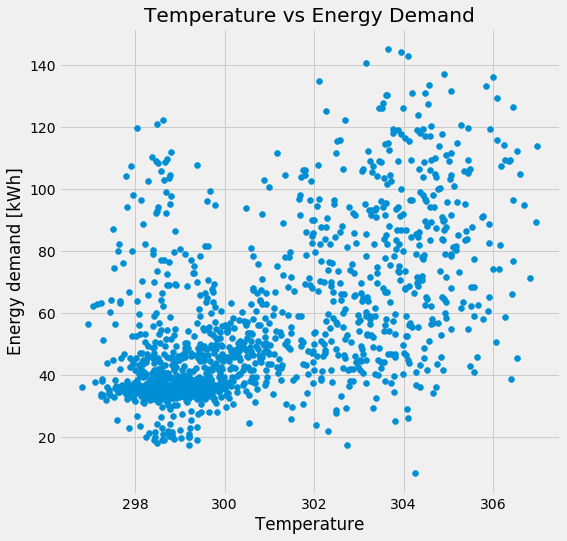

In [20]:
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

In [21]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [22]:
endog = y_train.ix[:,0]
exog = sm.add_constant(y_train.ix[:,1:])

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


## Training

In [35]:
predictions = []
window = 24*5

In [24]:
prediction_b1, prediction_b2 = baseline_forecasts(y_train,window,'H')


baseline - previous...
Baseline-previous test RMSE 21403.5660155
baseline - averages....
Baseline-averages test RMSE 12059.7161498


In [36]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [26]:
sp = Sarima_predictions(params_s, 0)
results_s = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
sp = Sarima_predictions(params_sX,1)
results_sX = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
sp = Sarima_predictions(params_sX_v,2)
results_sX_v = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)

In [37]:
predictions.append(['sarima',results_s[0]])
predictions.append(['sarimaX_f',results_sX[0]])
# predictions.append(['sarimaX_v',results_sX_v])

In [34]:

results_s

(array([  43248.33862132,   38443.34727319,   33254.50248303,
          35186.31685387,   36792.90640885,   36384.16130163,
          33835.22310137,   33966.41659385,   47127.60576571,
          84545.0346144 ,   51251.52579196,   70910.41854436,
          97451.92409008,   78563.68850667,   82105.30394777,
          93628.38403024,  110105.00008632,  112745.9719029 ,
          91828.97618637,   88562.45729959,   57884.13886398,
          53757.28997425,   46043.24258666,   39337.27022125,
          44725.0093436 ,   39271.50345961,   21157.38737086,
          35798.44106415,   33404.54445496,   34656.06943944,
          38511.34211719,   37292.38277277,   44747.57278935,
          89482.34031417,   47033.0476184 ,   72166.76470516,
          90066.79579977,   70538.63683241,   81269.73726307,
         107690.99791834,  111153.44302405,  124303.87591988,
          81364.51968506,   84592.34729397,   53987.40470171,
          49713.72987182,   46886.9289257 ,   43405.97200374,
        

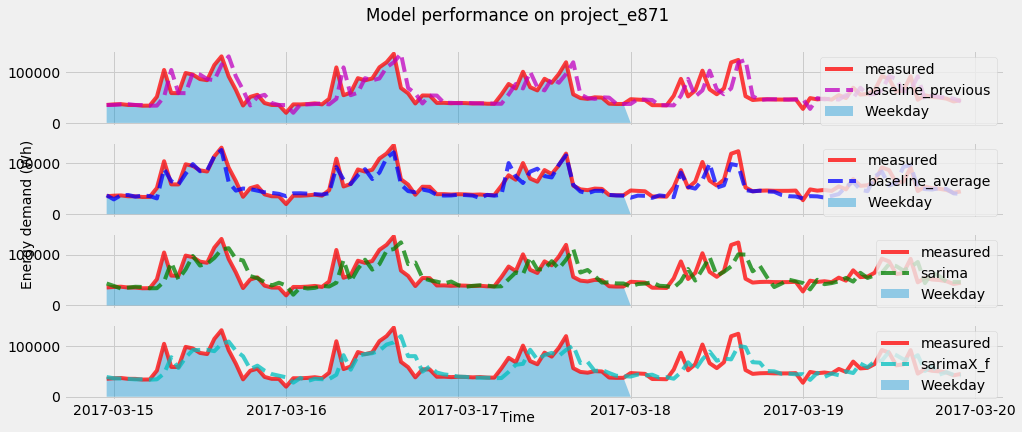

In [40]:
line_plot_predictions(project_name, predictions,y_train.iloc[-24*5:])

In [ ]:
sp = Sarima_predictions(params_sX)
model = sp.fit_sarimaX((y_train.iloc[:,0],y_train.iloc[:,1:]))
model.summary()

In [163]:
sp = Sarima_predictions(params_sX_v)
model = sp.fit_sarimaX((y_train.iloc[:,0],y_train.iloc[:,1:]),var=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              power_all   No. Observations:                 5038
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -70432.164
Date:                Sat, 02 Sep 2017   AIC                         140874.328
Time:                        13:53:38   BIC                         140906.952
Sample:                    01-01-2017   HQIC                        140885.757
                         - 07-29-2017                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1           0.0673      0.010      7.010      0.000       0.048       0.086
ma.L2          -0.0509      0.012     -4.196      0.000      -0.075      -0.027
var.T-1         1.0000   7455.634      0.000      1.000   -1.46e+04    1.46e+04
var.weekday     1.0000      0.273      3.659      0.000       0.464       1.536
sigma2       8.391e+10      0.075   1.13e+12      0.000    8.39e+10    8.39e+10
===================================================================================
Ljung-Box (Q):                      571.30   Jarque-Bera (JB):             17043.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.43e+25. Standard errors may be unstable.
"""

## Forecasts

In [164]:
forecasts = []

In [165]:
forecast_b1, forecast_b2 = baseline_forecasts(y,2*season,'H')


baseline - previous...
Baseline-previous test RMSE 125586.234991
baseline - averages....
Baseline-averages test RMSE 262847.253112


In [166]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [167]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2)
sp = Sarima_predictions(params_sX_v)
results_sX_v = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2,var=True)

In [168]:
forecast_s = results_s['sarima'][0]
forecast_sX = results_sX['sarimaX'][0]
forecast_sX_v = results_sX_v['sarimaX'][0]


In [169]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])
forecasts.append(['sarimaX_f_v',forecast_sX_v])

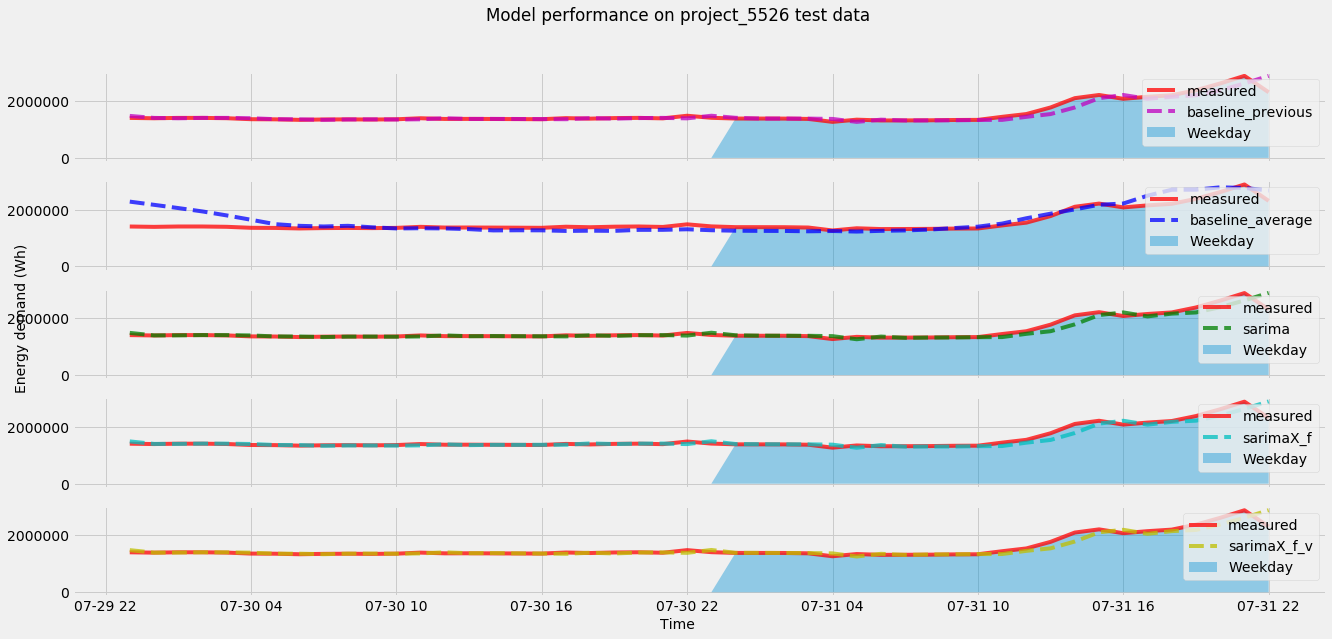

In [170]:
line_plot_predictions(project_name, forecasts,y_test)